# Per-capita GHG emissions of selected EU countries

This notebooks details the data preparation and plotting of the chart showing the per-capita emissions of greenhouse gases of selected EU member states.

## Load prerequisities

This notebooks uses the Tidyverse libraries and the `eurostat` package. To install these libraries, run the command `install.packages(c("eurostat", "tidyverse"))` in your R instance.

In [ ]:
library(eurostat)
library(tidyverse)

theme_set(theme_void())

## Parameters

In [2]:
selected_year <- 2021
# Vector of country codes to include in the chart.
selected_countries <- c("CZ", "DE", "FR", "HU", "PL", "SE", "SK")

# Names and colours for the individual emissions categories.
# Note that the order of categories here determines the order
# in the chart below – the first category is in the center,
# the others are placed around it in clockwise direction.
category_colours <-
  c(PowerHeat   = "#ff4245",
    Transport   = "#a10014",
    Buildings   = "#00007f",
    Industry    = "#3891dc",
    Agriculture = "#1ecfbd",
    Waste       = "#029485",
    Other       = "#f8c551")

# Width/height of the largest square in the chart.
max_size <- 40
# Spacing between squares and indent of labels from square sides.
spacing <- 2
# Number of squares in each region: top, right, bottom.
layout <- c(2, 2, 2)

assertthat::assert_that(length(layout) == 3)
assertthat::assert_that(1 + sum(layout) == length(category_colours))

[1] TRUE

[1] TRUE

## Emissions and population data

This visualization uses two datasets from the Eurostat database:

- [Greenhouse gas emissions by source sector](https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE) from EEA (product code `env_air_gge`) and
- [Population on 1 January](https://ec.europa.eu/eurostat/web/products-datasets/-/TPS00001) (product code `tps00001`).

In [ ]:
# Population numbers in the given year.
population <-
  get_eurostat("tps00001",
               filters = list(time = selected_year),
               time_format = "num") |>
  select(CountryCode = geo,
         Population  = values)

# Emissions numbers for all countries, selected sectors and years.
selected_emissions <-
  get_eurostat("env_air_gge",
               filters = list(airpol = "GHG",
                              time   = selected_year,
                              unit   = "MIO_T"),
               time_format = "num") |>
  filter(geo %in% selected_countries) |>
  select(CountryCode = geo,
         Code        = src_crf,
         Value       = values) |>
  # Join with population data and recalculate emissions
  # per capita (t CO₂/person).
  left_join(population, join_by(CountryCode)) |>
  replace_na(list(Value = 0)) |>
  mutate(Value = Value / (Population / 1e6)) |>
  # Pivot to a wide tibble for easier calculations.
  pivot_wider(names_from = "Code", values_from = "Value") |>
  # Group into sectors by summing components.
  transmute(CountryCode = CountryCode,
            PowerHeat   = CRF1A1A,
            Industry    = CRF1A2 + CRF1A1B + CRF1A1C + CRF1A3E + CRF2 + CRF1B,
            Transport   = CRF1A3A + CRF1A3B + CRF1A3C + CRF1A3D + CRF1D1A,
            Buildings   = CRF1A4A + CRF1A4B,
            Agriculture = CRF3 + CRF1A4C,
            Waste       = CRF5,
            Other       = TOTX4_MEMONIA - PowerHeat - Industry - Transport -
              Buildings - Agriculture - Waste) |>
  # Turn back into long format.
  pivot_longer(-CountryCode,
               names_to = "Category",
               values_to = "Value") |>
  mutate(# Note that the "Other" category may become slightly negative for
         # countries with very little emissions outside the main categories
         # due to rounding errors. Clamp emissions values to zero to prevent
         # issues later.
         Value = pmax(0, Value),
         # Enforce order of categories as declared above.
         across(Category, ~ factor(., levels = names(category_colours))))

## Chart plotting

We can now prepare the data for plotting. This is done by separating the categories into four groups, each of which will be plotted in a particular spot in the chart: center, top, right and bottom.

In [6]:
compute_square_coords <- function(x, y, width, spacing, label_position = "bottom") {
  if (label_position == "bottom") {
    label_vjust <- 0
    label_x <- x + width - spacing
    label_y <- y + width - spacing
  } else if (label_position == "top") {
    label_vjust <- 1
    label_x <- x + width - spacing
    label_y <- y + spacing
  } else {
    stop(glue::glue("Invalid label position ‘{label_position}’, ",
                    "expected ‘bottom’ or ‘top’"))
  }

  tibble(x, y, width, label_x, label_y, label_vjust)
}

# Helper function to prepare square coordinates for a single country.
make_squares_for_country <- function(.row, categories, size) {
  # We assume the y-inverted coordinate system:
  # x grows to the right, y grows down.

  # Center tile.
  width_center <- (width <- size(.row[[categories[[1]]]]))
  output <- tibble(Category = categories[[1]],
                   Coords = compute_square_coords(0, 0, width, spacing))

  # Top tiles.
  x <- width_center
  y <- -spacing
  for (category in rev(categories[[2]])) {
    width <- size(.row[[category]])
    x <- x - width
    output <- output |>
      rbind(tibble(Category = category,
                   Coords = compute_square_coords(x, y - width, width, spacing)))
    x <- x - spacing
  }

  # Right tiles.
  x <- width_center + spacing
  y <- width_center
  for (category in rev(categories[[3]])) {
    width <- size(.row[[category]])
    y <- y - width
    output <- output |>
      rbind(tibble(Category = category,
                   Coords = compute_square_coords(x, y, width, spacing)))
    y <- y - spacing
  }

  # Bottom tiles.
  x <- 0
  y <- width_center + spacing
  for (category in rev(categories[[4]])) {
    width <- size(max(0, .row[[category]]))
    # Skip zero-size tiles.
    if (width == 0) next
    output <- output |>
      rbind(tibble(Category = category,
                   Coords = compute_square_coords(x, y, width, spacing, "top")))
    x <- x + width + spacing
  }

  return(output |> unnest(Coords))
}

make_squares <- function(.data, layout, max_size, spacing = 1) {
  # Maximum amount of emissions in the whole dataset.
  max_value <- max(.data$Value, na.rm = TRUE)
  # Size (width/height) scale for the squares.
  size <- \(x) sqrt(x / max_value) * max_size

  # Split categories into groups by position according to the layout.
  categories <- levels(.data$Category)
  groups <- cumsum(seq_along(categories) %in% cumsum(c(2, layout)))
  cats_split <- split(categories, groups) |> unname()

  wide <- .data |>
    select(CountryCode, Category, Value) |>
    pivot_wider(names_from = "Category", values_from = "Value") |>
    column_to_rownames("CountryCode")

  rownames(wide) |>
    # Calculate square coordinates for each country and category.
    map(function(CountryCode) {
      Squares <- make_squares_for_country(wide[CountryCode, ], cats_split, size)
      tibble(CountryCode, Squares)
    }) |>
    list_rbind() |>
    # Join in original data (emissions amounts).
    left_join(.data, join_by(CountryCode, Category))
}

The resulting data frame ready for plotting looks like this:

In [8]:
squares_data <- make_squares(selected_emissions, layout, max_size, spacing)

squares_data |>
  mutate(across(where(is.numeric), ~ round(.x, 2))) |>
  head(10)

CountryCode,Category,x,y,width,label_x,label_y,label_vjust,Value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CZ,PowerHeat,0.00,0.00,38.60,36.60,36.60,0,3.75
CZ,Buildings,17.61,-22.98,20.98,36.60,-4.00,0,1.11
CZ,Transport,-11.41,-29.02,27.02,13.61,-4.00,0,1.84
CZ,Agriculture,40.60,20.05,18.54,57.14,36.60,0,0.86
CZ,Industry,40.60,-17.56,35.61,74.21,16.05,0,3.19
CZ,Other,0.00,40.60,6.07,4.07,42.60,1,0.09
CZ,Waste,8.07,40.60,14.70,20.77,42.60,1,0.54
DE,PowerHeat,0.00,0.00,31.81,29.81,29.81,0,2.54
DE,Buildings,8.15,-25.66,23.66,29.81,-4.00,0,1.41


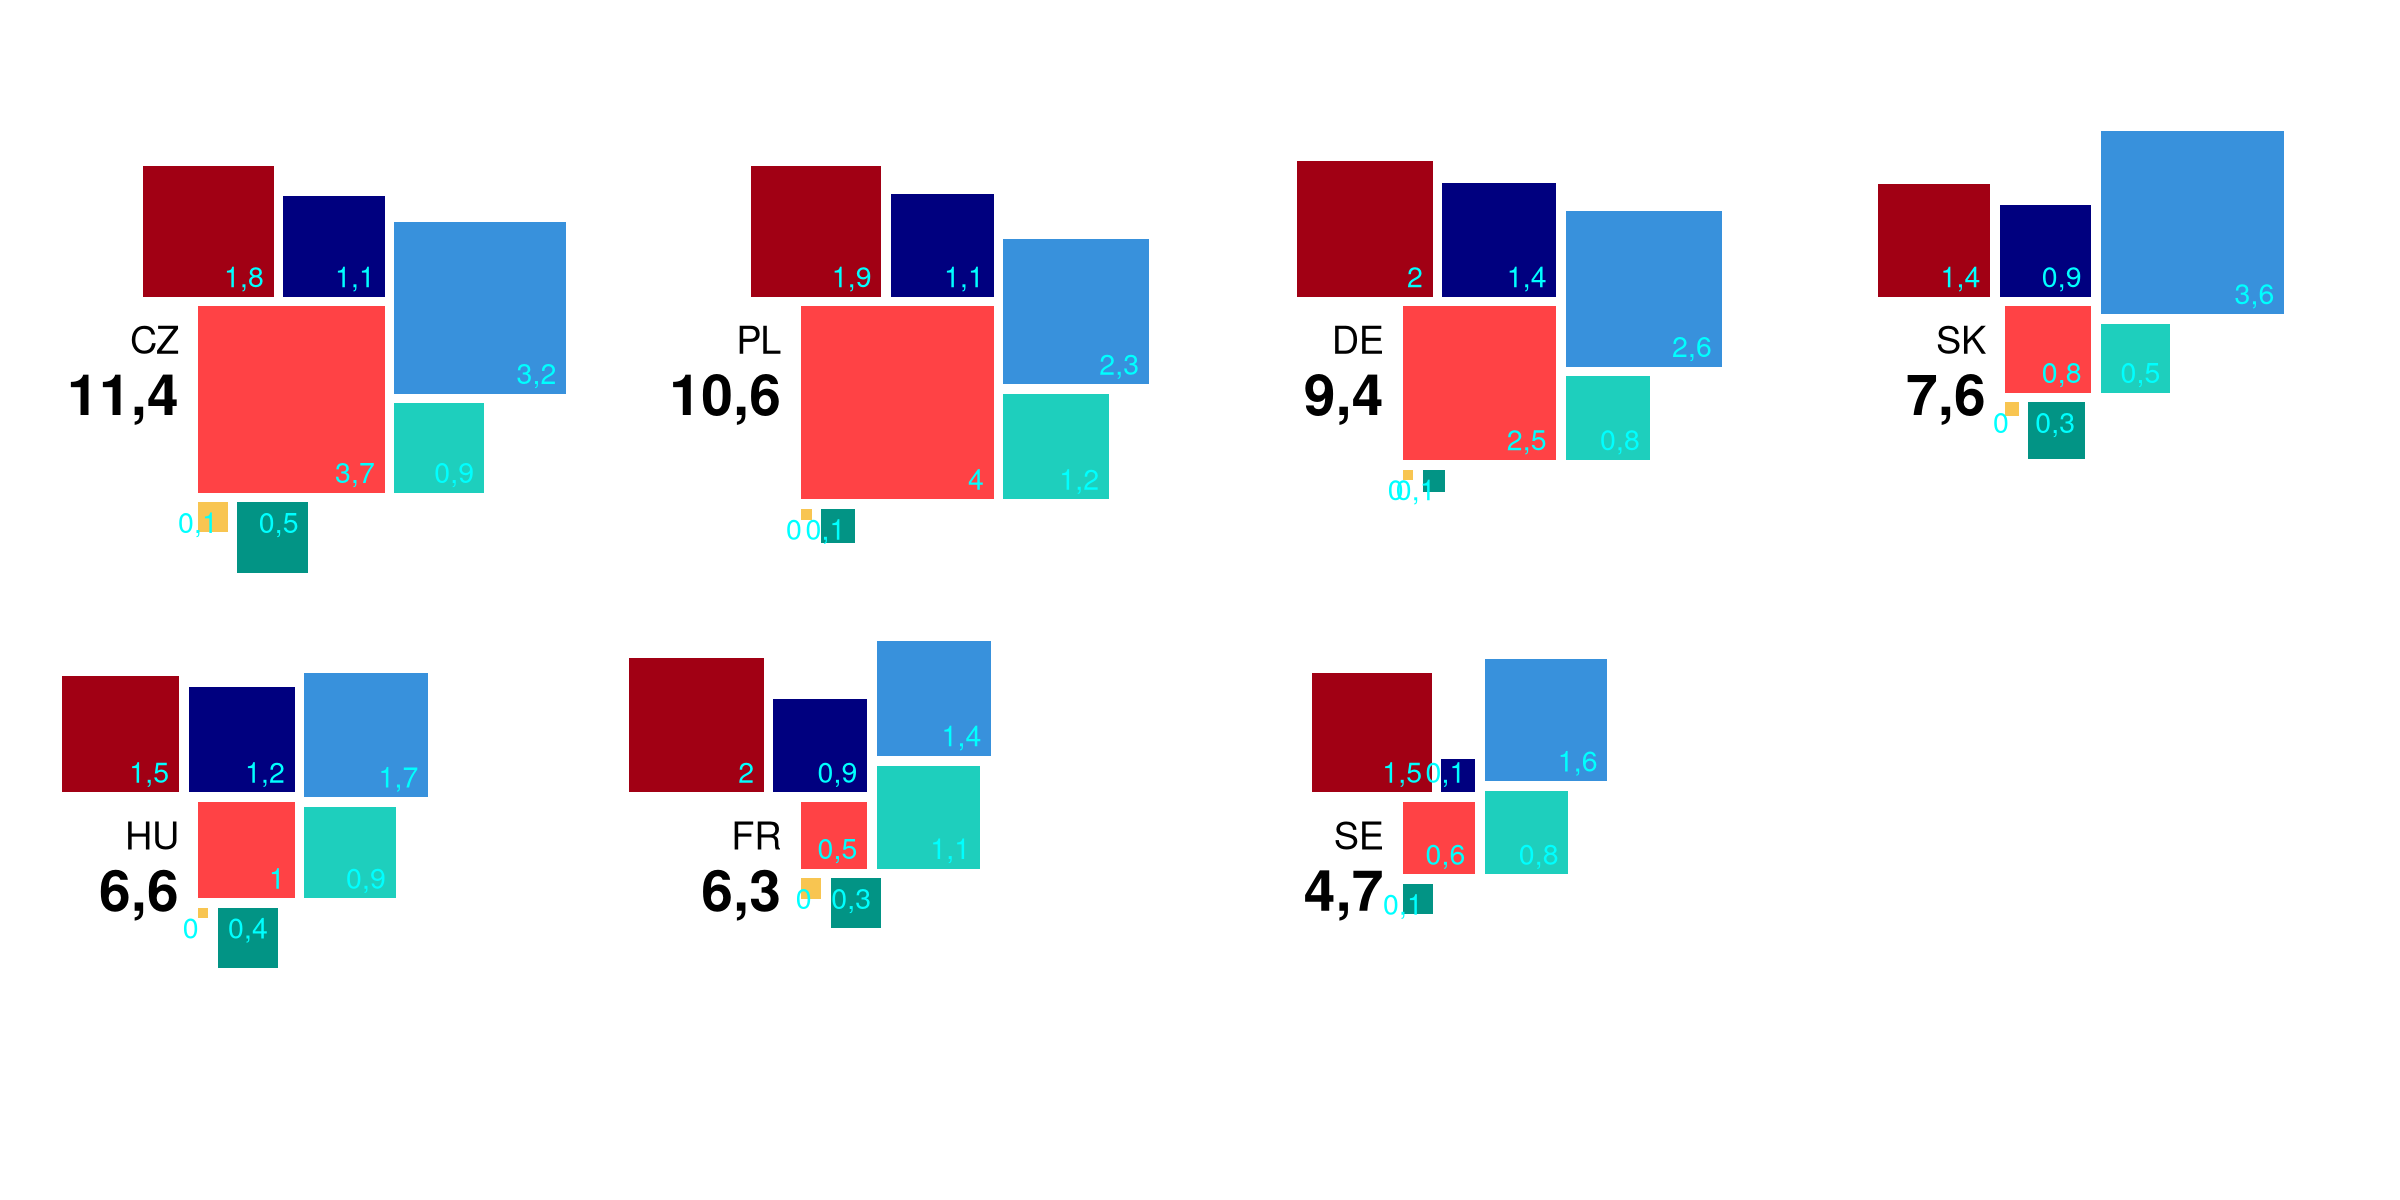

In [9]:
# Use a comma for decimal separator.
options(repr.plot.width = 20, repr.plot.height = 10, OutDec = ",")

country_totals <- selected_emissions |>
  summarise(TotalPerCapita = sum(Value), .by = CountryCode) |>
  # Sort countries by total per-capita emissions.
  mutate(CountryCode = fct_reorder(CountryCode, -TotalPerCapita))

squares_plot <- squares_data |>
  # Sort countries by total per-capita emissions.
  mutate(CountryCode = fct_reorder(CountryCode, -Value, sum)) |>
  ggplot() +
  # Individual squares for each category.
  geom_rect(aes(xmin = x,
                ymin = y,
                xmax = x + width,
                ymax = y + width,
                fill = Category)) +
  # Labels for values in each category.
  geom_text(aes(x = label_x,
                y = label_y,
                label = round(Value, 1),
                vjust = label_vjust),
            colour = "cyan", hjust = 1, size = 6) +
  # Country code labels.
  geom_text(aes(-4, 4, label = CountryCode),
            data  = country_totals,
            size  = 8,
            hjust = 1,
            vjust = 1) +
  # Total country per-capita labels.
  geom_text(aes(-4, 14, label = round(TotalPerCapita, 1)),
            data = country_totals,
            size = 12,
            fontface = "bold",
            hjust = 1,
            vjust = 1) +
  scale_fill_manual(values = category_colours) +
  facet_wrap(vars(CountryCode), nrow = 2) +
  scale_y_reverse() +
  coord_fixed(clip = "off") +
  theme(legend.position = "none",
        strip.text = element_blank())

squares_plot

In [ ]:
# Used for exports only.

svglite::svglite("emissions-selected-countries.svg", width = 20, height = 10)
squares_plot
dev.off()